In [1]:
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import BeliefPropagation
import networkx as nx
import pylab as plt
import numpy
numpy.random.seed(0)
import random
random.seed(0)

Import the required libraries.
<br>We set random.seed so that the 'random' graph can be re-created.

In [2]:
chest_clinic_model = BayesianModel([('Asia', 'Tub'), 
                              ('Smoke', 'Lung'),
                              ('Smoke', 'Bronc'),
                              ('Tub', 'Either'),
                              ('Lung', 'Either'),
                              ('Either', 'Xray'),
                              ('Either', 'Dyspnoea'),
                              ('Bronc', 'Dyspnoea')])

#Creating Contiditional probability distribution table
cpd_asia = TabularCPD(variable='Asia', variable_card=2,
                      values=[[0.01], [0.99]])
cpd_smoke = TabularCPD(variable='Smoke', variable_card=2,
                       values=[[0.5], [0.5]])
cpd_tub = TabularCPD(variable='Tub', variable_card=2,
                      values=[[0.05, 0.01], [0.95, 0.99]],
                      evidence=['Asia'], evidence_card=[2])
cpd_lung = TabularCPD(variable='Lung', variable_card=2,
                      values=[[0.1, 0.01], [0.9, 0.99]],
                      evidence=['Smoke'], evidence_card=[2])

cpd_bronc = TabularCPD(variable='Bronc', variable_card=2,
                      values=[[0.6, 0.3], [0.4, 0.7]],
                      evidence=['Smoke'], evidence_card=[2])

cpd_either = TabularCPD(variable='Either', variable_card=2,
                        values=[[1, 1, 1, 0],
                                [0, 0, 0, 1]],
                        evidence=['Lung', 'Tub'],
                        evidence_card=[2, 2])

cpd_xray = TabularCPD(variable='Xray', variable_card=2,
                      values=[[0.98, 0.05], [0.02, 0.95]],
                      evidence=['Either'], evidence_card=[2])

cpd_dysp = TabularCPD(variable='Dyspnoea', variable_card=2,
                        values=[[0.9, 0.7, 0.8, 0.1],
                                [0.1, 0.3, 0.2, 0.9]],
                        evidence=['Bronc', 'Either'],
                        evidence_card=[2, 2])
# Associating the parameters with the model structure.
chest_clinic_model.add_cpds(cpd_asia, cpd_smoke, cpd_tub, cpd_lung, cpd_bronc, cpd_xray, cpd_either, cpd_dysp)

Create a BayesianModel using the pgmpy library
<br<br>Create the graph by defining the edges of the graph in a list.
<br><br> Then define all the conditional probability densities.
<br><br> Then add all dependencies to the model.


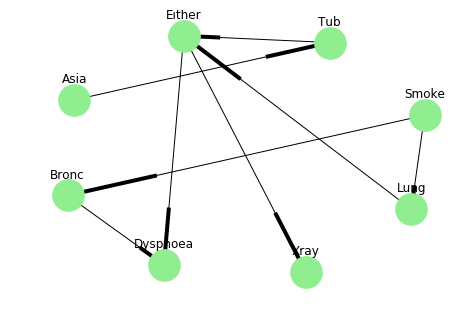

In [4]:
#Bayes Directed Graph
pos = nx.spring_layout(chest_clinic_model)
nx.draw(chest_clinic_model,pos, font_weight='bold',node_color='lightgreen', with_labels = False, arrows = True, node_size = 1000, style = 'solid')
for p in pos:
    pos[p][1] += 0.09

nx.draw_networkx_labels(chest_clinic_model, pos)
plt.savefig('Bayes_model.png')

Draw the Bayes graph

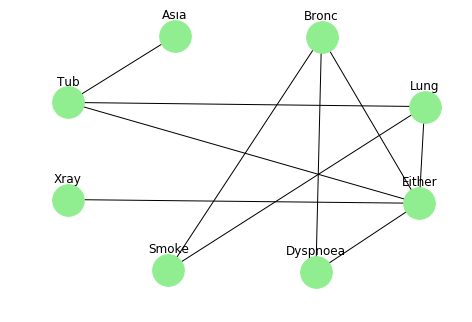

In [5]:
#Moralized graph
moralized = chest_clinic_model.to_markov_model()
pos = nx.spring_layout(moralized)
plt.figure()
nx.draw(moralized,pos, font_weight='bold',node_color='lightgreen',with_labels = False, arrows = False, node_size = 1000, style = 'solid')
for p in pos:
    pos[p][1] += 0.09

nx.draw_networkx_labels(moralized, pos)
plt.savefig('Moralized.png')

Draw the moralized graph

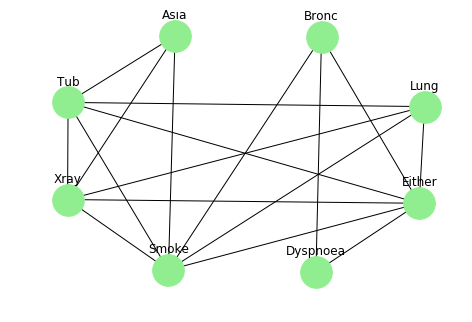

In [20]:
#Triangulated
triangulated = moralized.triangulate()
pos = nx.spring_layout(triangulated)
plt.figure()
nx.draw(triangulated,pos, font_weight='bold',node_color='lightgreen',with_labels = False, arrows = False, node_size = 1000, style = 'solid')
for p in pos:
    pos[p][1] += 0.09

nx.draw_networkx_labels(triangulated, pos)
plt.savefig('Triangulated.png')

Draw the Triangulated graph

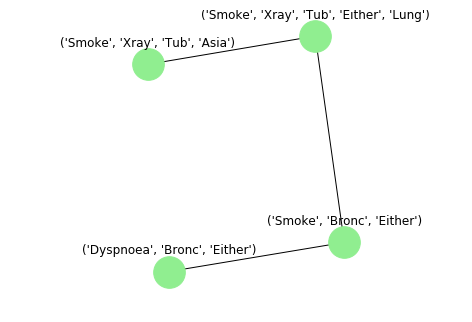

In [21]:
#Junction tree
junction_tree = triangulated.to_junction_tree()
pos = nx.spring_layout(junction_tree)

plt.figure()

nx.draw(junction_tree,pos, font_weight='bold',node_color='lightgreen',with_labels = False, arrows = False, node_size = 1000, style = 'solid')
for p in pos:
    pos[p][1] += 0.09

nx.draw_networkx_labels(junction_tree, pos)
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.6
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.savefig('Junction_tree.png')

Draw the Junction tree

# Running Intersection Property

1) Consider two clusters in the in the junction tree.If these two clusters have a common node, the Running Intersection Property is said to be satisfied if the common node is included in all clusters between the two clusters.
<br><br>2) In our junction tree, we see that this condition is satisfied.
<br><br>3) Ex.  For the clusters {Dysp,Either,Bronc} , {Smoke, Either, Bronc}, {Smoke,Either,Tub,Lung} .'Either' is present in the first and last cluster. The fact that 'Either' is present in the middle cluster as well means that the Running Intersection Property is true for these clusters.
<br><br>4) It can be seen that the above is true for all the other nodes of our junction tree as well. Therefore, the junction tree satisfies the running intersection property.

In [15]:
#Querying moralized graph with given variables and evidence
inference = VariableElimination(moralized)
phi_query = inference.max_marginal(variables=['Tub', 'Lung','Bronc'],evidence={'Asia': 1, 'Xray': 1})
print('The maximum marginal for the variables Tub,Lung and Broc given evidence is ' + str(phi_query))

#Doing Belief propogation
bp = BeliefPropagation(moralized)
bp.calibrate()
print('The clusters are:- \n')
cliq = bp.get_clique_beliefs()
for i in cliq:
    print(i)
ans = bp.query(variables=['Tub', 'Lung','Bronc'],evidence={'Asia': 1,'Xray': 1})
print('\nGiven evidence: Asia,Xray = yes and to find joint probability Tub,Lung,Bronc = yes \n')
print(ans['Tub']*ans['Lung']*ans['Bronc'])



The maximum marginal for the variables Tub,Lung and Broc given evidence is 0.620883452760265
The clusters are:- 

('Smoke', 'Xray', 'Tub', 'Asia')
('Smoke', 'Xray', 'Tub', 'Either', 'Lung')
('Smoke', 'Bronc', 'Either')
('Dyspnoea', 'Bronc', 'Either')

Given evidence: Asia,Xray = yes and to find joint probability Tub,Lung,Bronc = yes 

+-------+--------+---------+-----------------------+
| Tub   | Lung   | Bronc   |   phi(Tub,Lung,Bronc) |
+=======+========+=========+=======================+
| Tub_0 | Lung_0 | Bronc_0 |                0.0000 |
+-------+--------+---------+-----------------------+
| Tub_0 | Lung_0 | Bronc_1 |                0.0000 |
+-------+--------+---------+-----------------------+
| Tub_0 | Lung_1 | Bronc_0 |                0.0001 |
+-------+--------+---------+-----------------------+
| Tub_0 | Lung_1 | Bronc_1 |                0.0001 |
+-------+--------+---------+-----------------------+
| Tub_1 | Lung_0 | Bronc_0 |                0.0005 |
+-------+--------+---------

The clusters of the junction tree are displayed above.
<br><br>As we can see, the joint probabilities are given above with Tub,Lung,Bronc being 0.5562.

As we see in the Junction tree above, the clusters are :-<br><br>
$Node 1:\{Dysp,Bronc,Either\}$<br><br>
$Common: Bronc,Either $<br><br>
$Node 2:\{Smoke,Bronc,Either\}$<br><br>
$Common:Either, Smoke $<br><br>
$Node 3:\{Smoke,Xray,Tub,Either,Lung\}$<br><br>
$Common: Smoke,Xray,Tub$<br><br>
$Node 4:\{Smoke,Xray,Tub,Asia\}$<br><br>

The equation representing the entire graph is:- <br><br>

$p(V ) = p(a)p(t | a)p(s)p(l | s)p(b | s)p(e | t, l)p(d | e, b)p(x | e)$<br><br>

We distribute these probabilities into potentials:-<br><br>

$\Psi(D,B,E) = p(d | e, b)$<br><br>
$\Psi(S,B,E) = p(b | s)$<br><br>
$\Psi(S,X,T,E,L) = p(x | e)p(e | t, l)p(l | s)$<br><br>
$\Psi(S,X,T,A) = p(a)p(t | a)p(s) = \Psi(S,T,A)$<br><br>

First, the message passing occurs between Node 4 and Node 3.<br><br>
A is the only element which is not common.<br><br>
We sum over A.<br><br>




# Iteration 1:<br><br>

Message is sent from Node 4 to Node 3.<br><br>
$\sum_{a} \Psi(S,T,A) = \sum_{a} p(a)p(t | a)p(s)$<br><br>
S and T can be Yes or No.<br><br>
Now the new \Psi(S,X,T,E,L) at Node 3 will become:-<br><br>
$\Psi(S,X,T,E,L)' = \Psi(S,X,T,E,L)\sum_{a} \Psi(S,T,A)$<br><br>
It can be proven that:- <br><br>
$\frac{\Psi(S,T,A)}{\sum_{a} \Psi(S,T,A)} = p(a)p(t | a)p(s)$<br><br>
We get <br><br>
$\Psi(D,B,E)\Psi(S,B,E)\Psi(S,X,T,E,L)\sum_{a} \Psi(S,T,A) = P(A,T,X,D,B,L,S)$
$\sum_{a}\Psi(D,B,E)\Psi(S,B,E)\Psi(S,X,T,E,L)\Psi(S,T,A) = P(A,T,X,D,B,L,S)$

# Iteration 2:<br><br>
Message is sent from Node 3 to Node 2.<br><br>
$\sum_{b}\Psi(S,X,T,E,L)' = \sum_{b} p(x | e)p(e | t, l)p(l | s) \Psi(S,T,A)$<br><br>
The sum term on the RHS is 1. So, we can exclude it.<br><br>
$\frac{\Psi(S,X,T,E,L)'}{\sum{b} \Psi(S,X,T,E,L)'} = Conditional probability$ <br><br>
The above is further simplified. <br><br>
We see that <br><br>
$\Psi(S,B,E)  \Psi(S,X,T,E,L)' = Marginal Probability$

# Iteration 3:<br><br>
Message is sent from Node 2 to Node 1.<br><br>
# Iteration 4:<br><br>
Message is sent from Node 1 to Node 2.<br><br>
# Iteration 5:<br><br>
Message is sent from Node 2 to Node 3.<br><br>
# Iteration 6:<br><br>
Message is sent from Node 3 to Node 4.<br><br>

# After all the message passing is complete, what we have will be the marginals.